In [2]:
# This is needed to import the CC and EC Models from this location in this project.
import sys
sys.path.append("..")

from MagneticFluxRopeModels.ECModel import ECModel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [ ]:
def compute_intermediate_axis(B_field: np.ndarray, normalise: bool = False) -> np.ndarray:
    if normalise:
        B_field_mag = np.linalg.norm(B_field, axis=1)
        B_field = B_field / B_field_mag[:, np.newaxis]

    M = np.cov(B_field.transpose())
    eigenvalues, W = np.linalg.eig(M)

    index_min: int = np.argmin(eigenvalues)
    index_max: int = np.argmax(eigenvalues)
    index_intermediate: int = 3 - index_min - index_max

    estimated_ax = W[:, index_intermediate]

    # Correct the sign.
    if estimated_ax[2] < 0:
        estimated_ax *= (-1)

    return estimated_ax

Idea: How good is intermediate variance?

In [40]:
N_IMPACT_PARAMETER = 101
N_EXPERIMENTS = 1
y_0_range = np.linspace(-0.95, 0.95, N_IMPACT_PARAMETER, endpoint=True)
epsilon = 0.08
noise_type = None

df = []

time_stencil = np.linspace(0, 1, 51)

for idx, y_0 in enumerate(y_0_range):
    for n_experiment in range(N_EXPERIMENTS):
        for delta in np.linspace(0.25, 1.0, 31, endpoint=True):
            # Instantiate the EC model.
            ec_model = ECModel(delta=delta, psi=math.radians(30))
            random_seed = N_EXPERIMENTS*idx + n_experiment
  
            # Create the result dict.
            result = {"y_0": y_0, "random_seed": random_seed, "epsilon": epsilon, "noise_type": noise_type, "delta": delta}
            
            # Simulate the crossing.
            df_test = ec_model.simulate_crossing(v_sc=450, y_0=y_0, theta=0.0, time_stencil=time_stencil, noise_type=noise_type, random_seed=random_seed, epsilon=epsilon)
            if df_test is None:
               continue

            # Extract the magnetic field and compute the intermediate axis.
            B_field = df_test[["B_x", "B_y", "B_z"]].to_numpy()

            intermediate_ax = compute_intermediate_axis(B_field, normalise=False)
            intermediate_angle_difference = np.rad2deg(np.arccos(intermediate_ax[2]))

            normalised_intermediate_ax = compute_intermediate_axis(B_field, normalise=True)
            normalised_intermediate_angle_difference = np.rad2deg(np.arccos(normalised_intermediate_ax[2]))

            # Save the axis data into the dictionary.
            result["e_x"], result["e_y"], result["e_z"] = intermediate_ax
            result["angle_difference"] = intermediate_angle_difference
            result["normalised_e_x"], result["normalised_e_y"], result["normalised_e_z"] = normalised_intermediate_ax
            result["normalised_angle_difference"] = normalised_intermediate_angle_difference

            df.append(result)

# Convert the list[dict] to a dataframe.
df = pd.DataFrame(df)

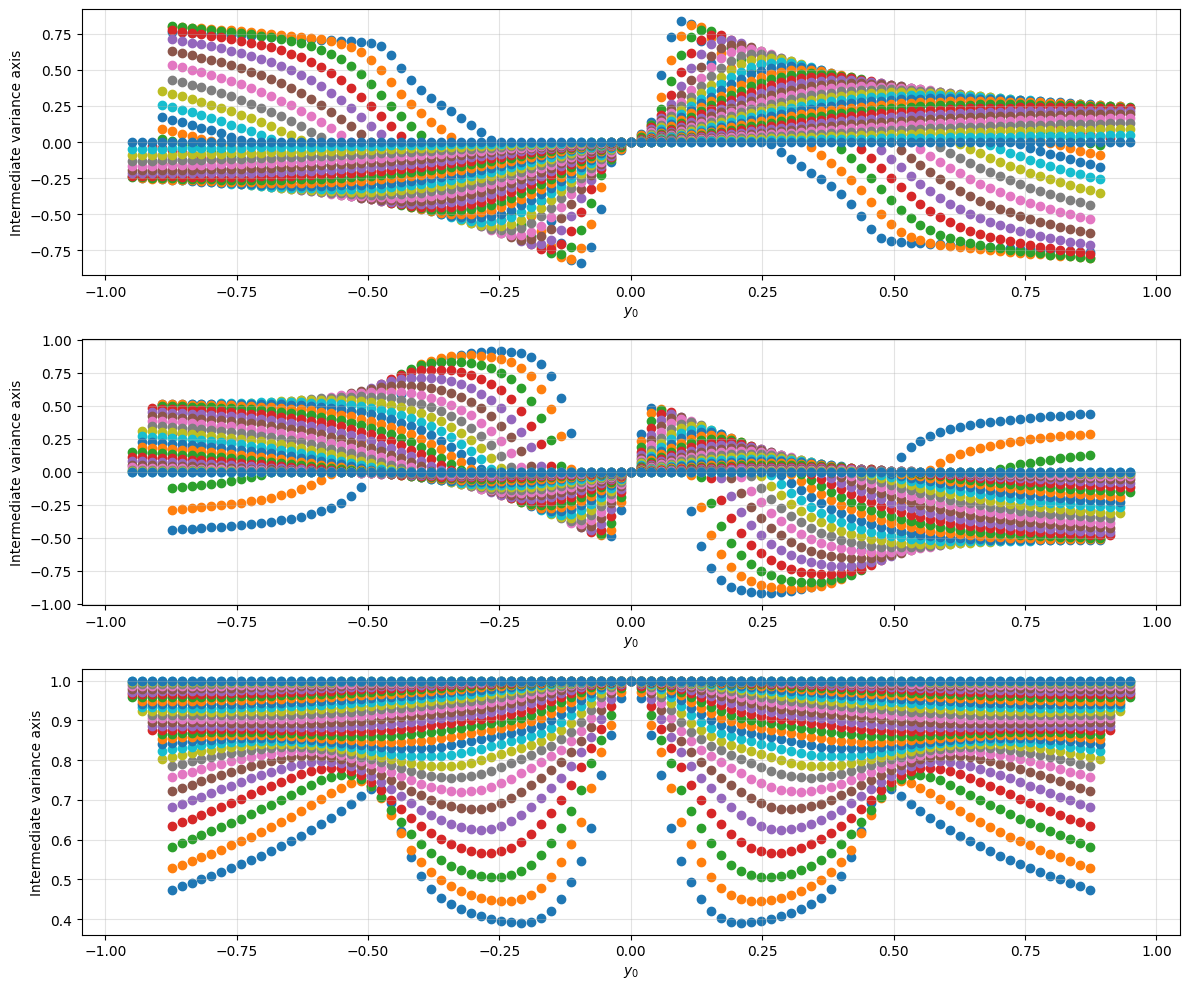

In [41]:
n_plots = 3
fig, ax = plt.subplots(n_plots, 1, tight_layout=True, figsize=(12, 10))
distinct_deltas = sorted(list(set(df["delta"])))

for delta in distinct_deltas:
    df_filtered = df.loc[df["delta"] == delta, :]
    ax[0].scatter(df_filtered["y_0"], df_filtered["e_x"], label="$e_x$")
    ax[1].scatter(df_filtered["y_0"], df_filtered["e_y"], label="$e_y$")
    ax[2].scatter(df_filtered["y_0"], df_filtered["e_z"], label="$e_z$")

for i in range(n_plots):
    ax[i].set_xlabel("$y_0$")
    ax[i].set_ylabel("Intermediate variance axis")
    ax[i].grid(alpha=0.35)

plt.show()

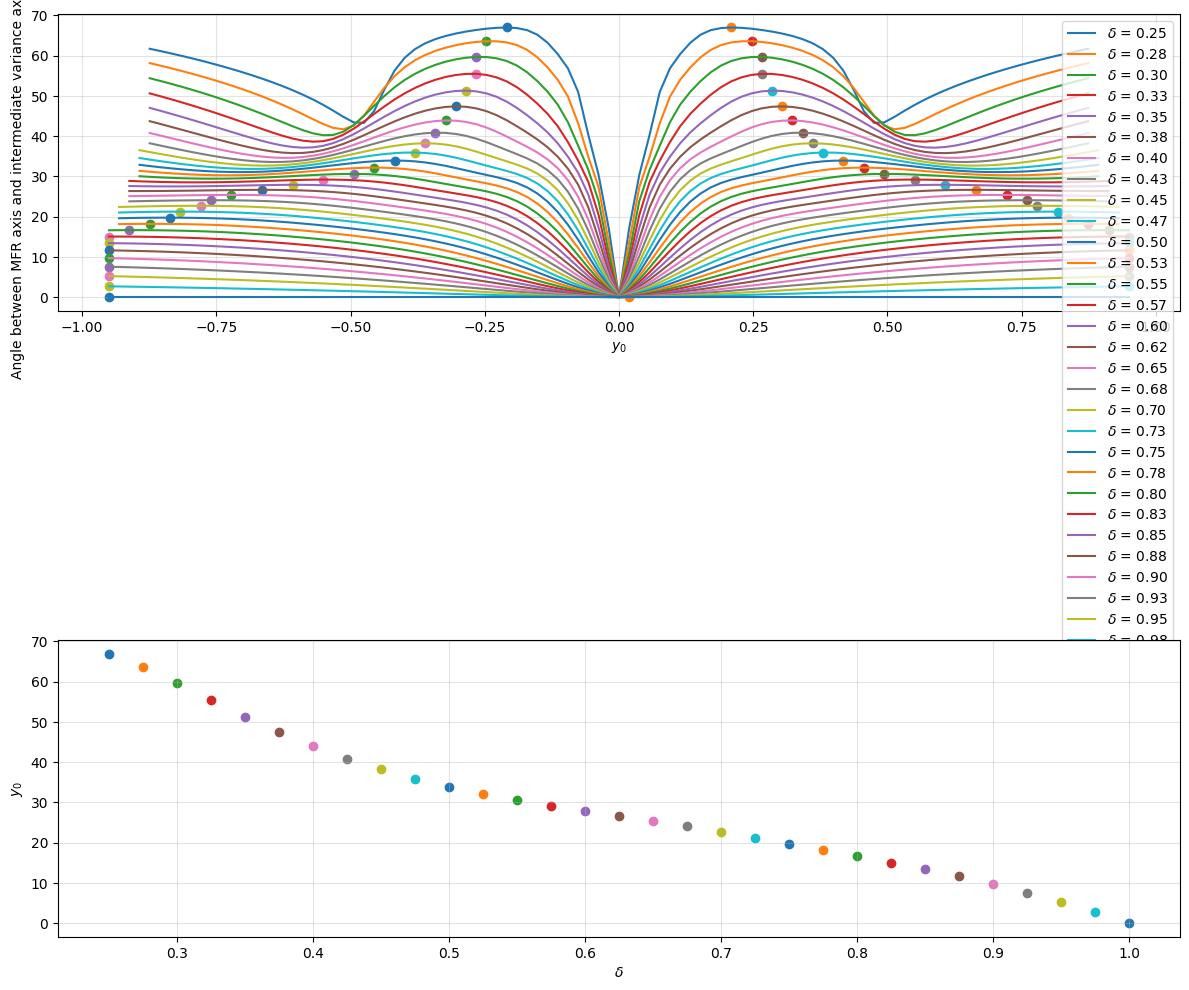

In [42]:
fig, ax = plt.subplots(2, 1, tight_layout=True, figsize=(12, 10))
for delta in distinct_deltas:
    # if delta > 1 - 1e-6:
    #     continue
    df_filtered = df.loc[df["delta"] == delta, :]
    # Left peak.
    df_filtered_left = df_filtered.loc[df_filtered["y_0"] < 0, :].reset_index(drop=True)
    left_maximum_idx = int(np.argmax(df_filtered_left["angle_difference"]))
    max_left_angle_difference = df_filtered_left.loc[left_maximum_idx, "angle_difference"]
    left_maximum_y_0 = df_filtered_left.loc[left_maximum_idx, "y_0"]

    # Right peak.
    df_filtered_right = df_filtered.loc[df_filtered["y_0"] > 0, :].reset_index(drop=True)
    right_maximum_idx = int(np.argmax(df_filtered_right["angle_difference"]))
    max_right_angle_difference = df_filtered_right.loc[right_maximum_idx, "angle_difference"]
    right_maximum_y_0 = df_filtered_right.loc[right_maximum_idx, "y_0"]

    ax[0].plot(df_filtered["y_0"], df_filtered["angle_difference"], "-", label=f"$\\delta$ = {delta:.2f}")
    ax[0].scatter(left_maximum_y_0, max_left_angle_difference)
    ax[0].scatter(right_maximum_y_0, max_right_angle_difference)

    ax[1].scatter(delta, max_right_angle_difference)

ax[0].set_xlabel("$y_0$")
ax[0].set_ylabel("Angle between MFR axis and intermediate variance axis (deg)")
ax[0].legend()
ax[0].grid(alpha=0.35)

ax[1].set_xlabel("$\\delta$")
ax[1].set_ylabel("$y_0$")
ax[1].grid(alpha=0.35)
plt.show()

In [43]:
# Contour plot
X, Y = np.meshgrid(y_0_range, distinct_deltas)
Z = np.zeros((len(distinct_deltas), len(y_0_range)))

for i in range(len(distinct_deltas)):
    for j in range(len(y_0_range)):
        try:
            x = df.loc[(df["y_0"] == y_0_range[j]) & (df["delta"] == distinct_deltas[i]), "angle_difference"]
            Z[i, j] = x.iloc[0]
        except IndexError:
            Z[i, j] = np.nan

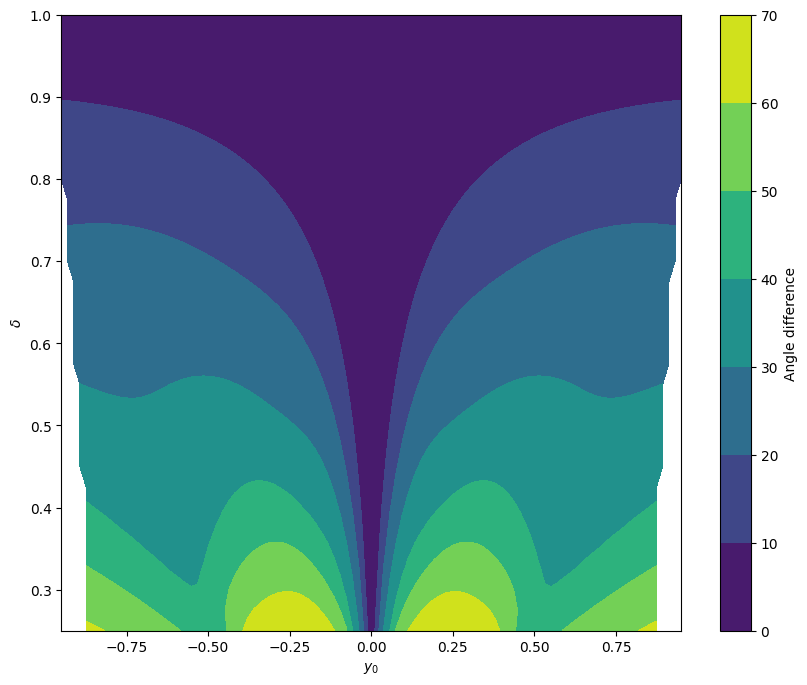

In [44]:
fig, ax = plt.subplots(figsize=(10, 8))
contour = ax.contourf(X, Y, Z)
ax.set_xlabel("$y_0$")
ax.set_ylabel("$\\delta$")
plt.colorbar(contour, label="Angle difference")

Idea: use intermediate variance method for this, to determine the flux-rope axis. This way we do no rely on the optimiser to do so ans achieve better performance.
If there is noise, this noise should affect all coordinates at the same time, so this method should be robust to noise.